# Data analysis using time variables

In this notebook we will analyze data using temporal variables.
Data refer to loans made

## About the data

The data set is a record of a Dutch financial institute, where it contains information on loans made between the years 2016 through early 2017.

## Data visualization
### Loading libraries

In [86]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
from matplotlib import pyplot
from sklearn import tree
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import OneHotEncoder, label_binarize
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, average_precision_score

### Reading the Data

In [45]:
raw_data = pd.read_csv('BPI_Challenge_2017.csv')
raw_data.columns.values

array(['Action', 'org:resource', 'concept:name', 'EventOrigin', 'EventID',
       'lifecycle:transition', 'time:timestamp', 'case:LoanGoal',
       'case:ApplicationType', 'case:concept:name',
       'case:RequestedAmount', 'FirstWithdrawalAmount', 'NumberOfTerms',
       'Accepted', 'MonthlyCost', 'Selected', 'CreditScore',
       'OfferedAmount', 'OfferID'], dtype=object)

### Correcting column names

Some columns come with complicated formatting to understand, so this action and makes it necessary for better visualization.

In [46]:
fix_cols_names = lambda x: re.sub( '(?<!^)(?=[A-Z])', '_', x.replace('ID','Id')).lower().replace(':','_').replace('__','_')
fixed_app_cols = [fix_cols_names(col) for col in raw_data.columns]
raw_data.columns = fixed_app_cols

### Creating columns with temporary data

Columns have been created

* 'datetime': transforms the 'time_timestamp' column to the date format
* 'month': indicates the month of registration
* 'week': indicates the week of the record





In [47]:
raw_data['datetime'] = pd.to_datetime(raw_data.time_timestamp)
raw_data['month'] = pd.DatetimeIndex(raw_data.datetime).month
raw_data['week'] = raw_data['datetime'].dt.strftime('%G%V')

The data looks like this with the new columns

In [48]:
raw_data

,action,org_resource,concept_name,event_origin,event_id,lifecycle_transition,time_timestamp,case_loan_goal,case_application_type,case_concept_name,case_requested_amount,first_withdrawal_amount,number_of_terms,accepted,monthly_cost,selected,credit_score,offered_amount,offer_id,datetime,month,week
0,Created,User_1,A_Create Application,Application,Application_652823628,complete,2016-01-01 09:51:15.304000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 09:51:15.304000+00:00,1,201553
1,statechange,User_1,A_Submitted,Application,ApplState_1582051990,complete,2016-01-01 09:51:15.352000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 09:51:15.352000+00:00,1,201553
2,Created,User_1,W_Handle leads,Workflow,Workitem_1298499574,schedule,2016-01-01 09:51:15.774000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 09:51:15.774000+00:00,1,201553
3,Deleted,User_1,W_Handle leads,Workflow,Workitem_1673366067,withdraw,2016-01-01 09:52:36.392000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 09:52:36.392000+00:00,1,201553
4,Created,User_1,W_Complete application,Workflow,Workitem_1493664571,schedule,2016-01-01 09:52:36.403000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 09:52:36.403000+00:00,1,201553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202262,Deleted,User_1,W_Call after offers,Workflow,Workitem_1817549786,ate_abort,2017-01-06 06:33:02.212000+00:00,Home improvement,New credit,Application_1350494635,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-01-06 06:33:02.212000+00:00,1,201701
1202263,Created,User_1,W_Call after offers,Workflow,Workitem_363876066,schedule,2017-01-06 06:33:02.221000+00:00,Home improvement,New credit,Application_1350494635,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-01-06 06:33:02.221000+00:00,1,201701
1202264,statechange,User_28,A_Cancelled,Application,ApplState_1869071797,complete,2017-01-16 09:51:21.114000+00:00,Home improvement,New credit,Application_1350494635,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-01-16 09:51:21.114000+00:00,1,201703
1202265,statechange,User_28,O_Cancelled,Offer,OfferState_420066181,complete,2017-01-16 09:51:21.139000+00:00,Home improvement,New credit,Application_1350494635,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Offer_1580299144,2017-01-16 09:51:21.139000+00:00,1,201703


## Exploratory analysis

In preparing the data, the following questions were raised:


1. Which month of the year did the most loan requests occur?
2. According to the purpose of the loan, which month had the most requests?
3. How many days does it take on average for an application that has been accepted to be completed?

To answer these questions, let's first separate the data just from creating the application.

In [49]:
only_creation_data = raw_data[raw_data['concept_name'] == 'A_Create Application']
only_creation_data

,action,org_resource,concept_name,event_origin,event_id,lifecycle_transition,time_timestamp,case_loan_goal,case_application_type,case_concept_name,case_requested_amount,first_withdrawal_amount,number_of_terms,accepted,monthly_cost,selected,credit_score,offered_amount,offer_id,datetime,month,week
0,Created,User_1,A_Create Application,Application,Application_652823628,complete,2016-01-01 09:51:15.304000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 09:51:15.304000+00:00,1,201553
40,Created,User_1,A_Create Application,Application,Application_1691306052,complete,2016-01-01 10:16:11.500000+00:00,Home improvement,New credit,Application_1691306052,10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 10:16:11.500000+00:00,1,201553
71,Created,User_1,A_Create Application,Application,Application_428409768,complete,2016-01-01 11:19:38.177000+00:00,Home improvement,New credit,Application_428409768,15000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 11:19:38.177000+00:00,1,201553
116,Created,User_1,A_Create Application,Application,Application_1746793196,complete,2016-01-01 12:34:53.911000+00:00,Car,New credit,Application_1746793196,5000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 12:34:53.911000+00:00,1,201553
200,Created,User_1,A_Create Application,Application,Application_828200680,complete,2016-01-01 13:00:04.360000+00:00,Home improvement,New credit,Application_828200680,35000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 13:00:04.360000+00:00,1,201553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202068,Created,User_1,A_Create Application,Application,Application_1107993134,complete,2016-12-31 15:38:12.302000+00:00,Car,New credit,Application_1107993134,5000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-12-31 15:38:12.302000+00:00,12,201652
1202113,Created,User_1,A_Create Application,Application,Application_2103458006,complete,2016-12-31 16:40:45.514000+00:00,Existing loan takeover,New credit,Application_2103458006,15000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-12-31 16:40:45.514000+00:00,12,201652
1202136,Created,User_1,A_Create Application,Application,Application_59622033,complete,2016-12-31 16:43:28.509000+00:00,Home improvement,New credit,Application_59622033,10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-12-31 16:43:28.509000+00:00,12,201652
1202193,Created,User_1,A_Create Application,Application,Application_303923658,complete,2016-12-31 16:59:16.240000+00:00,Car,New credit,Application_303923658,30000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-12-31 16:59:16.240000+00:00,12,201652


## Question 1: Which month of the year did the most loan requests occur?

As the month column was created, to answer this question, we grouped the application creation data by the month and had the following result.

In [50]:
creation_per_month = only_creation_data.month.value_counts().reset_index() \
                    .rename(index = str, columns = {'index':'month',
                                                    'month':'num_events'}) \
                    .sort_values('month') 
creation_per_month

,month,num_events
9,1,2194
7,2,2412
6,3,2454
10,4,2177
11,5,2068
3,6,3001
2,7,3039
0,8,3085
1,9,3042
4,10,2995


As you can see in the table above, the month with the most loan requests was the month 8 (August).

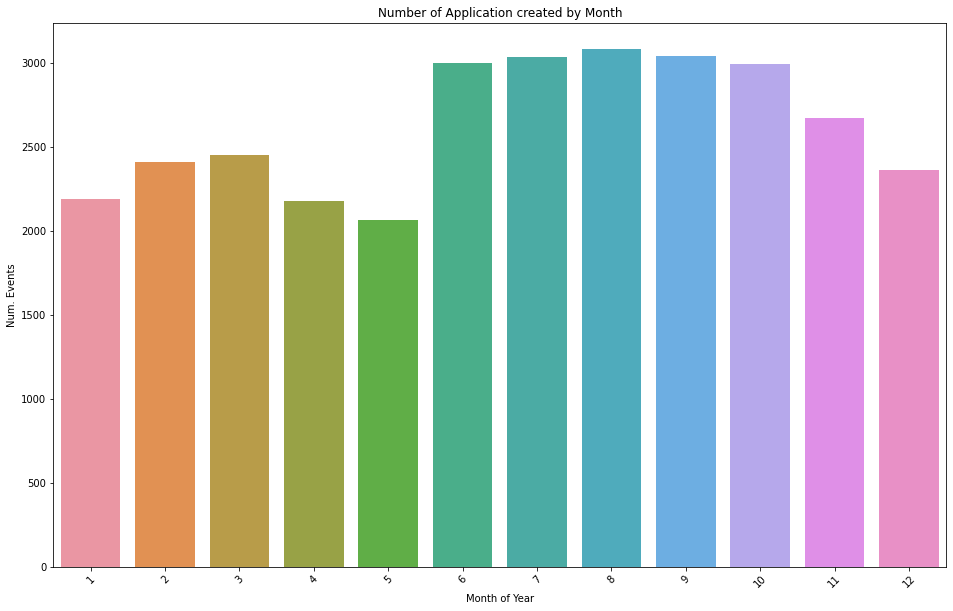

In [51]:
fig, ax = pyplot.subplots(figsize=(16,10))
g = sns.barplot(data = creation_per_month, x ='month', y= 'num_events');
g.set_xlabel('Month of Year')
g.set_ylabel('Num. Events')
g.set_title('Number of Application created by Month')
pyplot.xticks(rotation=45);

From the graph, we can see that the months from June to October have a number of loan requests with a value close to month 8. Coincidence or not, it is the summer time in Europe.

## Question 2: According to the purpose of the loan, which month had the most requests?

To answer this question, we created a new data table, which only has the purpose of the loan and the month that was requested.

In [90]:
filtered_data = pd.DataFrame(only_creation_data,columns=['case_loan_goal',  'month'])
filtered_data.sample(10)

,case_loan_goal,month
424194,Home improvement,5
1145614,Car,12
1061902,Car,11
1076675,Existing loan takeover,11
302818,Existing loan takeover,4
601696,Car,7
363874,Car,5
1015117,Home improvement,11
178003,Car,2
820328,Home improvement,9


With this data, we now create a new column where we count each goal occurrence per month and then filter, leaving only the one with the highest value.

In [91]:
grouped = (filtered_data.groupby(['case_loan_goal', 'month']).size()
              .sort_values(ascending=False).reset_index(name='count'))
grouped

,case_loan_goal,month,count
0,Car,8,865
1,Car,10,847
2,Car,6,841
3,Car,3,834
4,Home improvement,10,826
...,...,...,...
150,Business goal,7,1
151,Business goal,11,1
152,Business goal,12,1
153,Debt restructuring,8,1


With these data, it is possible to see, for each loan objective, which month there was a greater occurrence of requests.

Text(0.5, 1.0, 'Total Loan Request by month and loan goal')

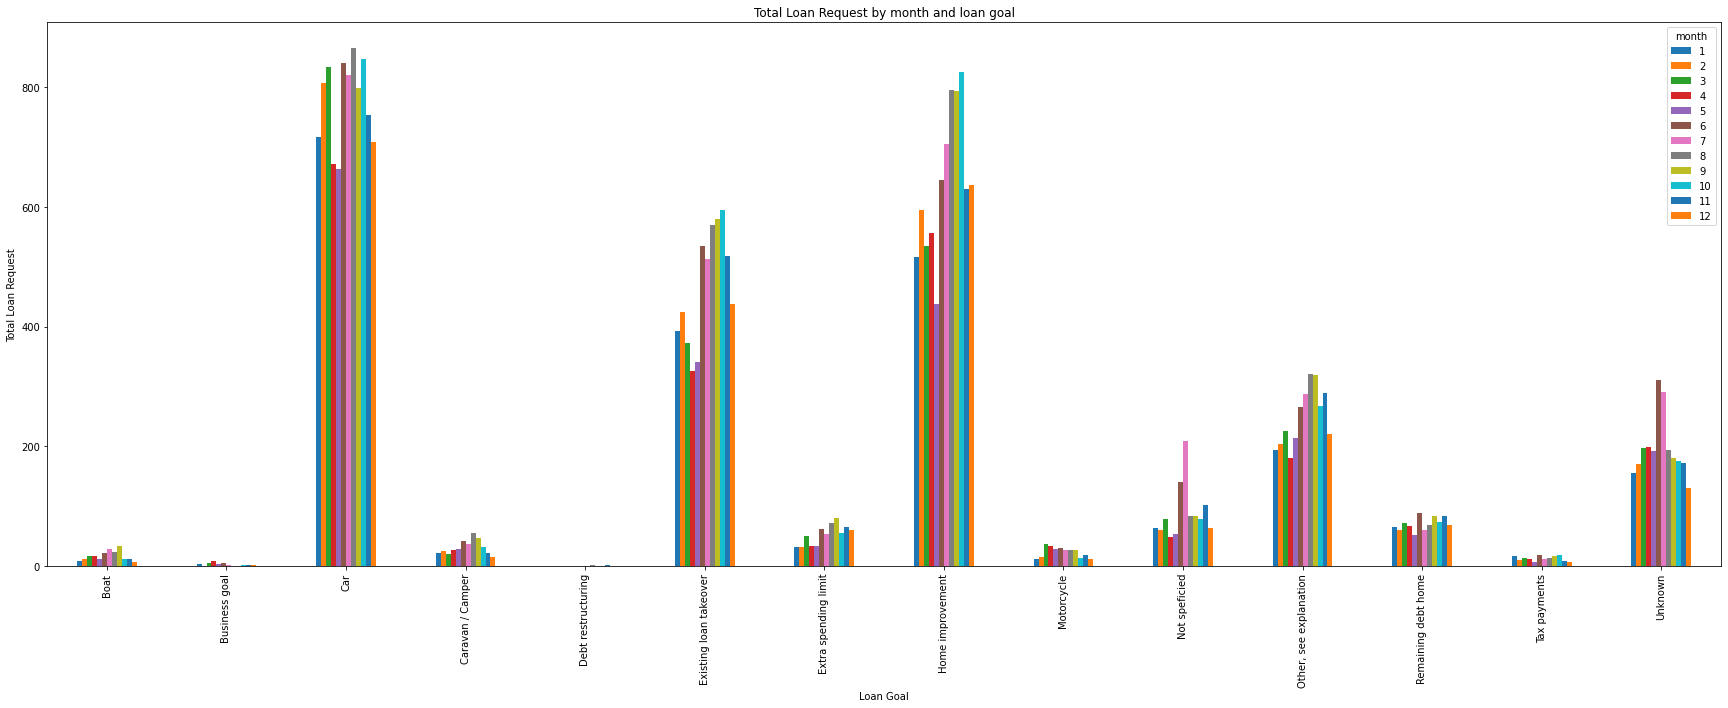

In [97]:
g = grouped.pivot_table(index='case_loan_goal', columns='month', values='count',
                        aggfunc='sum', fill_value=0).plot.bar(figsize=(30,10))
g.set_xlabel('Loan Goal')
g.set_ylabel('Total Loan Request')
g.set_title('Total Loan Request by month and loan goal')

Viewing the graph, we can see that some months have more orders for more than one objective. For example, in August, the largest number of loan applications for Car, Caravan / Camper and Other occurred. As in June, there are more orders for Remain Debit home, Tax Payments and Unknown.

## Question 3: How many days does it take on average for an application that has been accepted to be successfully completed?

First, I will leave only the two states in the dataset, creating and finalizing the application successfully, in order to be able to calculate the duration time.

In [55]:
only_app_data = raw_data[raw_data['event_origin'] == 'Application']
only_accepted_apps = only_app_data[(raw_data['concept_name'] == 'A_Create Application') | (raw_data['concept_name'] == 'A_Pending')]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [56]:
only_accepted_apps['concept_name'].value_counts()

A_Create Application    31509
A_Pending               17228
Name: concept_name, dtype: int64

By viewing the quantity of each one, it is possible to see that there is a part of the applications that were created that were not completed successfully, therefore, we will leave only those that were successfully completed.

In [57]:
listOfAppFinished = only_accepted_apps[only_accepted_apps['concept_name'] == 'A_Pending']['case_concept_name'].tolist()
only_accepted_data = only_accepted_apps[only_accepted_apps['case_concept_name'].isin(listOfAppFinished)]

In [58]:
only_accepted_data

,action,org_resource,concept_name,event_origin,event_id,lifecycle_transition,time_timestamp,case_loan_goal,case_application_type,case_concept_name,case_requested_amount,first_withdrawal_amount,number_of_terms,accepted,monthly_cost,selected,credit_score,offered_amount,offer_id,datetime,month,week
0,Created,User_1,A_Create Application,Application,Application_652823628,complete,2016-01-01 09:51:15.304000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 09:51:15.304000+00:00,1,201553
38,statechange,User_115,A_Pending,Application,ApplState_1179730815,complete,2016-01-14 15:49:11.420000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-14 15:49:11.420000+00:00,1,201602
71,Created,User_1,A_Create Application,Application,Application_428409768,complete,2016-01-01 11:19:38.177000+00:00,Home improvement,New credit,Application_428409768,15000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 11:19:38.177000+00:00,1,201553
114,statechange,User_90,A_Pending,Application,ApplState_16917315,complete,2016-01-14 07:00:14.450000+00:00,Home improvement,New credit,Application_428409768,15000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-14 07:00:14.450000+00:00,1,201602
116,Created,User_1,A_Create Application,Application,Application_1746793196,complete,2016-01-01 12:34:53.911000+00:00,Car,New credit,Application_1746793196,5000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 12:34:53.911000+00:00,1,201553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202111,statechange,User_83,A_Pending,Application,ApplState_407324650,complete,2017-01-23 07:06:27.167000+00:00,Car,New credit,Application_1107993134,5000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-01-23 07:06:27.167000+00:00,1,201704
1202136,Created,User_1,A_Create Application,Application,Application_59622033,complete,2016-12-31 16:43:28.509000+00:00,Home improvement,New credit,Application_59622033,10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-12-31 16:43:28.509000+00:00,12,201652
1202191,statechange,User_30,A_Pending,Application,ApplState_356117270,complete,2017-01-23 07:44:22.568000+00:00,Home improvement,New credit,Application_59622033,10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-01-23 07:44:22.568000+00:00,1,201704
1202193,Created,User_1,A_Create Application,Application,Application_303923658,complete,2016-12-31 16:59:16.240000+00:00,Car,New credit,Application_303923658,30000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-12-31 16:59:16.240000+00:00,12,201652


Now we are going to calculate the time it took from the creation of the application, to its state that it was successfully completed.

These data will be placed in a new data table where we have the name of the application and its duration.

In [59]:
spent_data = only_accepted_data.groupby(by='case_concept_name')['datetime'].agg(lambda x: x.max() - x.min()).reset_index()
spent_data

,case_concept_name,datetime
0,Application_1000158214,8 days 00:47:34.434000
1,Application_1000339879,12 days 20:14:38.437000
2,Application_100034150,11 days 03:18:00.362000
3,Application_1000386745,10 days 23:27:27.917000
4,Application_1000474975,12 days 19:29:33.659000
...,...,...
17223,Application_999487618,11 days 17:48:43.692000
17224,Application_999507989,6 days 07:14:35.733000
17225,Application_999544538,79 days 18:48:35.266000
17226,Application_999993467,13 days 18:42:42.747000


With the result in hand, all you have to do now is add this data with the general data to have the duration value of all the applications that were created successfully.

In [60]:
only_accepted_data = pd.merge(raw_data, spent_data, on='case_concept_name')
only_accepted_data

,action,org_resource,concept_name,event_origin,event_id,lifecycle_transition,time_timestamp,case_loan_goal,case_application_type,case_concept_name,case_requested_amount,first_withdrawal_amount,number_of_terms,accepted,monthly_cost,selected,credit_score,offered_amount,offer_id,datetime_x,month,week,datetime_y
0,Created,User_1,A_Create Application,Application,Application_652823628,complete,2016-01-01 09:51:15.304000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 09:51:15.304000+00:00,1,201553,13 days 05:57:56.116000
1,statechange,User_1,A_Submitted,Application,ApplState_1582051990,complete,2016-01-01 09:51:15.352000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 09:51:15.352000+00:00,1,201553,13 days 05:57:56.116000
2,Created,User_1,W_Handle leads,Workflow,Workitem_1298499574,schedule,2016-01-01 09:51:15.774000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 09:51:15.774000+00:00,1,201553,13 days 05:57:56.116000
3,Deleted,User_1,W_Handle leads,Workflow,Workitem_1673366067,withdraw,2016-01-01 09:52:36.392000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 09:52:36.392000+00:00,1,201553,13 days 05:57:56.116000
4,Created,User_1,W_Complete application,Workflow,Workitem_1493664571,schedule,2016-01-01 09:52:36.403000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01 09:52:36.403000+00:00,1,201553,13 days 05:57:56.116000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
779163,statechange,User_28,A_Validating,Application,ApplState_1546255688,complete,2017-01-23 13:46:33.802000+00:00,Car,New credit,Application_303923658,30000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-01-23 13:46:33.802000+00:00,1,201704,22 days 22:13:51.950000
779164,Released,User_28,W_Validate application,Workflow,Workitem_943020709,suspend,2017-01-23 13:46:53.705000+00:00,Car,New credit,Application_303923658,30000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-01-23 13:46:53.705000+00:00,1,201704,22 days 22:13:51.950000
779165,statechange,User_29,O_Accepted,Offer,OfferState_507784570,complete,2017-01-23 15:13:08.185000+00:00,Car,New credit,Application_303923658,30000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Offer_1734870628,2017-01-23 15:13:08.185000+00:00,1,201704,22 days 22:13:51.950000
779166,statechange,User_29,A_Pending,Application,ApplState_769143185,complete,2017-01-23 15:13:08.190000+00:00,Car,New credit,Application_303923658,30000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-01-23 15:13:08.190000+00:00,1,201704,22 days 22:13:51.950000


Before proceeding, we organized the data a bit, renaming the new column and removing others that were unnecessary.

In [61]:
only_accepted_data = only_accepted_data[only_accepted_data['case_concept_name'].isin(listOfAppFinished)]

In [62]:
only_accepted_data = only_accepted_data.drop(columns=['first_withdrawal_amount', 'number_of_terms','accepted','monthly_cost',
                                                      'selected','credit_score','offered_amount','offer_id', 'action', 'event_origin', 
                                                      'event_id', 'lifecycle_transition', ])
only_accepted_data = only_accepted_data.rename(columns={"datetime_y": "spent_time"})
only_accepted_data

,org_resource,concept_name,time_timestamp,case_loan_goal,case_application_type,case_concept_name,case_requested_amount,datetime_x,month,week,spent_time
0,User_1,A_Create Application,2016-01-01 09:51:15.304000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,2016-01-01 09:51:15.304000+00:00,1,201553,13 days 05:57:56.116000
1,User_1,A_Submitted,2016-01-01 09:51:15.352000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,2016-01-01 09:51:15.352000+00:00,1,201553,13 days 05:57:56.116000
2,User_1,W_Handle leads,2016-01-01 09:51:15.774000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,2016-01-01 09:51:15.774000+00:00,1,201553,13 days 05:57:56.116000
3,User_1,W_Handle leads,2016-01-01 09:52:36.392000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,2016-01-01 09:52:36.392000+00:00,1,201553,13 days 05:57:56.116000
4,User_1,W_Complete application,2016-01-01 09:52:36.403000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,2016-01-01 09:52:36.403000+00:00,1,201553,13 days 05:57:56.116000
...,...,...,...,...,...,...,...,...,...,...,...
779163,User_28,A_Validating,2017-01-23 13:46:33.802000+00:00,Car,New credit,Application_303923658,30000.0,2017-01-23 13:46:33.802000+00:00,1,201704,22 days 22:13:51.950000
779164,User_28,W_Validate application,2017-01-23 13:46:53.705000+00:00,Car,New credit,Application_303923658,30000.0,2017-01-23 13:46:53.705000+00:00,1,201704,22 days 22:13:51.950000
779165,User_29,O_Accepted,2017-01-23 15:13:08.185000+00:00,Car,New credit,Application_303923658,30000.0,2017-01-23 15:13:08.185000+00:00,1,201704,22 days 22:13:51.950000
779166,User_29,A_Pending,2017-01-23 15:13:08.190000+00:00,Car,New credit,Application_303923658,30000.0,2017-01-23 15:13:08.190000+00:00,1,201704,22 days 22:13:51.950000


So now to answer our question 3, just look at this new column.

In [63]:
only_accepted_data['spent_time'].describe()

count                      779168
mean      20 days 04:35:50.837805
std       13 days 05:55:56.484284
min        0 days 00:07:29.346000
25%       11 days 03:53:01.702000
50%       16 days 13:41:21.914000
75%       25 days 14:38:46.871000
max      145 days 21:54:09.869000
Name: spent_time, dtype: object

As we can see, on average, an application that was successfully completed, takes 20 days, 4 hours and 36 minutes approximately to be completed.

What drew attention, was this application finished in 7 minutes, we will pull data from it to see if it really happened or it was a data error.

In [64]:
only_accepted_data[only_accepted_data['spent_time'] == '0 days 00:07:29.346000']

,org_resource,concept_name,time_timestamp,case_loan_goal,case_application_type,case_concept_name,case_requested_amount,datetime_x,month,week,spent_time
231820,User_30,A_Create Application,2016-05-02 09:37:02.254000+00:00,Unknown,Limit raise,Application_2072748824,0.0,2016-05-02 09:37:02.254000+00:00,5,201618,00:07:29.346000
231821,User_30,A_Concept,2016-05-02 09:37:02.257000+00:00,Unknown,Limit raise,Application_2072748824,0.0,2016-05-02 09:37:02.257000+00:00,5,201618,00:07:29.346000
231822,User_30,W_Complete application,2016-05-02 09:37:02.269000+00:00,Unknown,Limit raise,Application_2072748824,0.0,2016-05-02 09:37:02.269000+00:00,5,201618,00:07:29.346000
231823,User_30,W_Complete application,2016-05-02 09:37:02.274000+00:00,Unknown,Limit raise,Application_2072748824,0.0,2016-05-02 09:37:02.274000+00:00,5,201618,00:07:29.346000
231824,User_30,A_Accepted,2016-05-02 09:38:14.429000+00:00,Unknown,Limit raise,Application_2072748824,0.0,2016-05-02 09:38:14.429000+00:00,5,201618,00:07:29.346000
231825,User_30,O_Create Offer,2016-05-02 09:39:23.068000+00:00,Unknown,Limit raise,Application_2072748824,0.0,2016-05-02 09:39:23.068000+00:00,5,201618,00:07:29.346000
231826,User_30,O_Created,2016-05-02 09:39:24.337000+00:00,Unknown,Limit raise,Application_2072748824,0.0,2016-05-02 09:39:24.337000+00:00,5,201618,00:07:29.346000
231827,User_30,O_Sent (online only),2016-05-02 09:39:50.508000+00:00,Unknown,Limit raise,Application_2072748824,0.0,2016-05-02 09:39:50.508000+00:00,5,201618,00:07:29.346000
231828,User_30,W_Complete application,2016-05-02 09:39:50.522000+00:00,Unknown,Limit raise,Application_2072748824,0.0,2016-05-02 09:39:50.522000+00:00,5,201618,00:07:29.346000
231829,User_30,W_Call after offers,2016-05-02 09:39:50.529000+00:00,Unknown,Limit raise,Application_2072748824,0.0,2016-05-02 09:39:50.529000+00:00,5,201618,00:07:29.346000


From what we see, it was really quickly finished after it opened. It is worth noting that the same user who created it, was the one who continued the whole process until the end, probably this influenced the speed.

#**Machine Learning**

In answering this question 3, the following question was raised. Will it be possible to create a classifier that predicts how long the application will be completed?

To answer this question, we start by selecting the features that I think are important to determine.

In [80]:
copy_df = only_accepted_data[['case_loan_goal', 'case_application_type', 'month', 'week', 'org_resource',
                          'case_requested_amount', 'spent_time']].copy(deep=True)

Creating new columns for objective and application types to be represented numerically

In [81]:
encoder = OneHotEncoder()

encoded_df_loan_goal = pd.DataFrame(encoder.fit_transform(copy_df[['case_loan_goal']]).toarray())
encoded_df_loan_goal.columns = encoder.get_feature_names(['case_loan_goal'])


encoded_df_app_type = pd.DataFrame(encoder.fit_transform(copy_df[['case_application_type']]).toarray())
encoded_df_app_type.columns = encoder.get_feature_names(['case_application_type'])

copy_df.drop(['case_loan_goal', 'case_application_type'], axis = 1, inplace = True)

copy_df = pd.concat([copy_df, encoded_df_loan_goal, encoded_df_app_type], axis = 1)

copy_df.dropna(inplace=True)

Creating a new column where the user working on the application can be represented numerically

In [82]:
codes, uniques = pd.factorize(copy_df['org_resource'].values)
codes_df = pd.DataFrame(data=codes, columns=['org_resource_num'])
copy_df = pd.concat([copy_df, codes_df], axis = 1)

Changing the duration column to be represented numerically

In [83]:
date_num = pd.DataFrame(copy_df['spent_time'].dt.days.astype('int16'))
copy_df.drop(['spent_time'], axis = 1, inplace = True)
copy_df = pd.concat([copy_df, date_num], axis = 1)
copy_df.dropna(inplace=True)

In [84]:
copy_df

,month,week,org_resource,case_requested_amount,case_loan_goal_Boat,case_loan_goal_Business goal,case_loan_goal_Car,case_loan_goal_Caravan / Camper,case_loan_goal_Existing loan takeover,case_loan_goal_Extra spending limit,case_loan_goal_Home improvement,case_loan_goal_Motorcycle,case_loan_goal_Not speficied,"case_loan_goal_Other, see explanation",case_loan_goal_Remaining debt home,case_loan_goal_Tax payments,case_loan_goal_Unknown,case_application_type_Limit raise,case_application_type_New credit,org_resource_num,spent_time
0,1,201553,User_1,20000.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,13
1,1,201553,User_1,20000.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,13
2,1,201553,User_1,20000.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,13
3,1,201553,User_1,20000.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,13
4,1,201553,User_1,20000.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
779163,1,201704,User_28,30000.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,45,22
779164,1,201704,User_28,30000.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,45,22
779165,1,201704,User_29,30000.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,34,22
779166,1,201704,User_29,30000.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,34,22


Dividing the data into training and testing.

In [87]:
x = copy_df[['month', 'week', 'case_requested_amount', 'org_resource_num',
             'case_loan_goal_Boat', 'case_loan_goal_Business goal', 'case_loan_goal_Car', 'case_loan_goal_Caravan / Camper',
             'case_loan_goal_Existing loan takeover', 'case_loan_goal_Extra spending limit', 'case_loan_goal_Home improvement',
             'case_loan_goal_Motorcycle', 'case_loan_goal_Not speficied', 'case_loan_goal_Other, see explanation',
             'case_loan_goal_Remaining debt home', 'case_loan_goal_Tax payments', 'case_loan_goal_Unknown',
             'case_application_type_Limit raise', 'case_application_type_New credit']].values

y = label_binarize(copy_df['spent_time'], classes=copy_df['spent_time'].unique())


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

Using Regression Decision Tree algorithm

In [89]:
tree_clf = tree.DecisionTreeRegressor()

tree_clf.fit(x_train,y_train)

y_pred=tree_clf.predict(x_test)

Result

In [ ]:
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))
print('Average precision-recall score: {0:0.2f}'.format(average_precision_score(y_test, y_pred)))

Mean squared error: 0.00
Coefficient of determination: 0.74
Average precision-recall score: 0.86


Changing the way to extract the Y to be able to generate the graph

In [99]:
y = copy_df['spent_time'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [100]:
tree_clf = tree.DecisionTreeRegressor()

tree_clf.fit(x_train,y_train)

y_pred=tree_clf.predict(x_test)

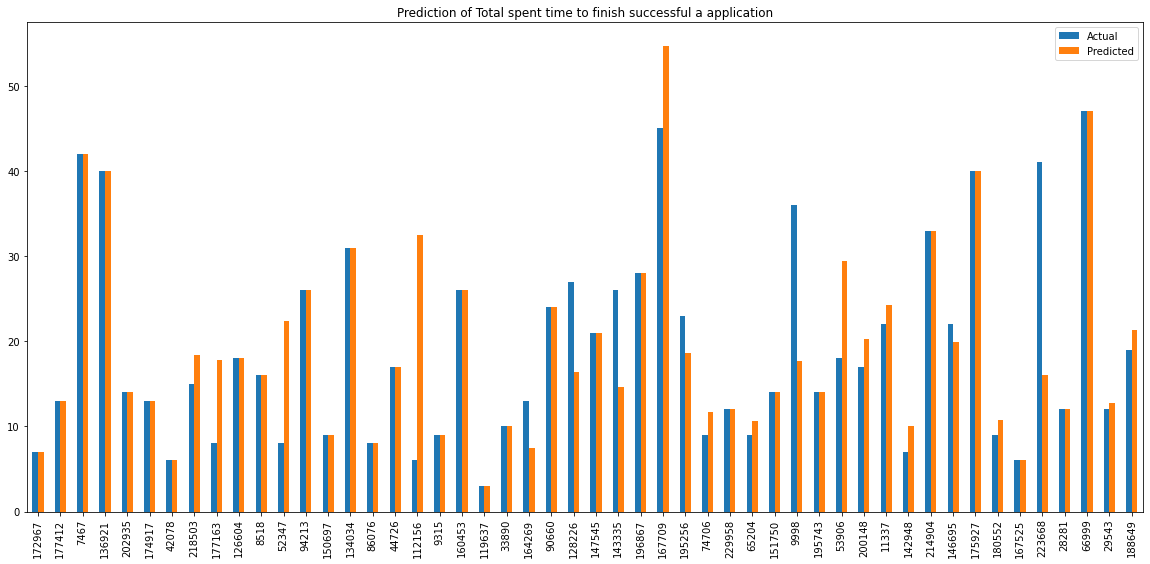

In [103]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1 = df.sample(50)
df1.plot(kind='bar',figsize=(20,9), title='Prediction of Total spent time to finish successful a application')